## Environment Preparation

In [1]:
# !pip install monai[tqdm]

In [2]:
# !git clone https://github.com/Project-MONAI/GenerativeModels.git

In [3]:
%cd GenerativeModels/
# !python setup.py install

/content/GenerativeModels


## Setup imports

In [4]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks import nets
from generative.networks.schedulers import DDPMScheduler

## Prepare Kvasir-SEG Dataset

In [5]:
set_determinism(42)

# !wget https://datasets.simula.no/downloads/kvasir-seg.zip
# !unzip kvasir-seg.zip

In [6]:
path_img = './Kvasir-SEG/images/'
path_msk = './Kvasir-SEG/masks/'
fnames_img = [f for f in os.listdir(path_img) if '.jpg' in f]
datalist = []
for fname in fnames_img:
    data = {'image': path_img+fname, 'seg': path_msk+fname}
    datalist.append(data)

# Shuffle
np.random.shuffle(datalist)
# Split the datalist to train and validation
train_datalist = datalist[:800]
val_datalist = datalist[800:]
datalist[:3]

[{'image': './Kvasir-SEG/images/cju2p4ddkmzxj0993p94o62av.jpg',
  'seg': './Kvasir-SEG/masks/cju2p4ddkmzxj0993p94o62av.jpg'},
 {'image': './Kvasir-SEG/images/cju8bh8surexp0987o5pzklk1.jpg',
  'seg': './Kvasir-SEG/masks/cju8bh8surexp0987o5pzklk1.jpg'},
 {'image': './Kvasir-SEG/images/cju45pm27n80u08174kyow1gj.jpg',
  'seg': './Kvasir-SEG/masks/cju45pm27n80u08174kyow1gj.jpg'}]

## Transforms and Dataloader Setup 

In [7]:
batch_size = 1
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Resized(keys=["image"], spatial_size=[256, 256]),
        transforms.NormalizeIntensityd(keys='image'),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
     transforms.Resized(keys=["image"], spatial_size=[256, 256]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

Loading dataset: 100%|██████████| 800/800 [00:35<00:00, 22.52it/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 200/200 [00:04<00:00, 44.99it/s]


## Training Data Preview

/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages direc

batch shape: torch.Size([1, 3, 256, 256])


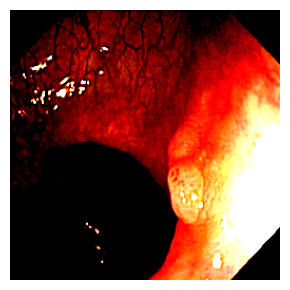

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = check_data["image"][0].numpy()
plt.figure("training images", (3, 3))
plt.imshow(image_visualisation.transpose([2, 1, 0]), vmin=0, vmax=1)
plt.axis("off")
plt.tight_layout()
plt.show()

## Define model, DDPM Scheduler and Inferer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nets.DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
    norm_num_groups=32,
)
model.to(device)

num_train_timesteps=1000
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
DDPMScheduler()
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)

inferer = DiffusionInferer(scheduler)

## Training

Epoch 5: 100%|█████████| 800/800 [06:11<00:00,  2.15it/s, loss=0.0251]
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only sto

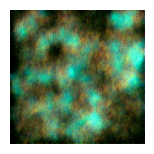

Epoch 8:  52%|████▋    | 414/800 [03:12<03:00,  2.14it/s, loss=0.0212]

In [ ]:
n_epochs = 50
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

# setting for Auto Mixed Precision (AMP)
scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch+1}")
    ## Training ##
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        # setting for Auto Mixed Precision (AMP)
        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    ## Validation ##
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1,)+tuple(images[0].shape))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=num_train_timesteps)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0].cpu().numpy().transpose([2,1,0]), vmin=0, vmax=1)
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [ ]:
model.eval()
val_epoch_loss = 0
for step, batch in enumerate(val_loader):
    images = batch["image"].to(device)
    with torch.no_grad():
        with autocast(enabled=True):
            noise = torch.randn_like(images).to(device)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            
            val_loss = F.mse_loss(noise_pred.float(), noise.float())

    val_epoch_loss += val_loss.item()

## DDPM Visualization

In [ ]:
def ddpm_vis():
    model.eval()
    noise = torch.randn((1, 3, 256, 256))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=num_train_timesteps)
    with autocast(enabled=True):
        image, intermediates = inferer.sample(
            input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=num_train_timesteps//10
        )

    chain = torch.cat(intermediates, dim=-1)

    plt.style.use("default")
    plt.imshow(chain[0].cpu().numpy().transpose([2,1,0]), vmin=0, vmax=1)
    plt.tight_layout()
    plt.axis("off")
    plt.show()

ddpm_vis()

In [ ]:
ddpm_vis()